# 51. RNN의 기초 원리를 배워봅시다.

* 서울의 주간평균기온 데이터를 이용하여 RNN 모델을 구현해 봅시다.

## 1.환경 준비

### (1) 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

### (2) 필요한 함수 생성

* 학습곡선 함수

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

* 데이터 2 --> 3차원 변환

In [3]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

### (3) Data Loading

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


## 2.데이터 이해

온도의 흐름(trend)을 살펴봅시다.

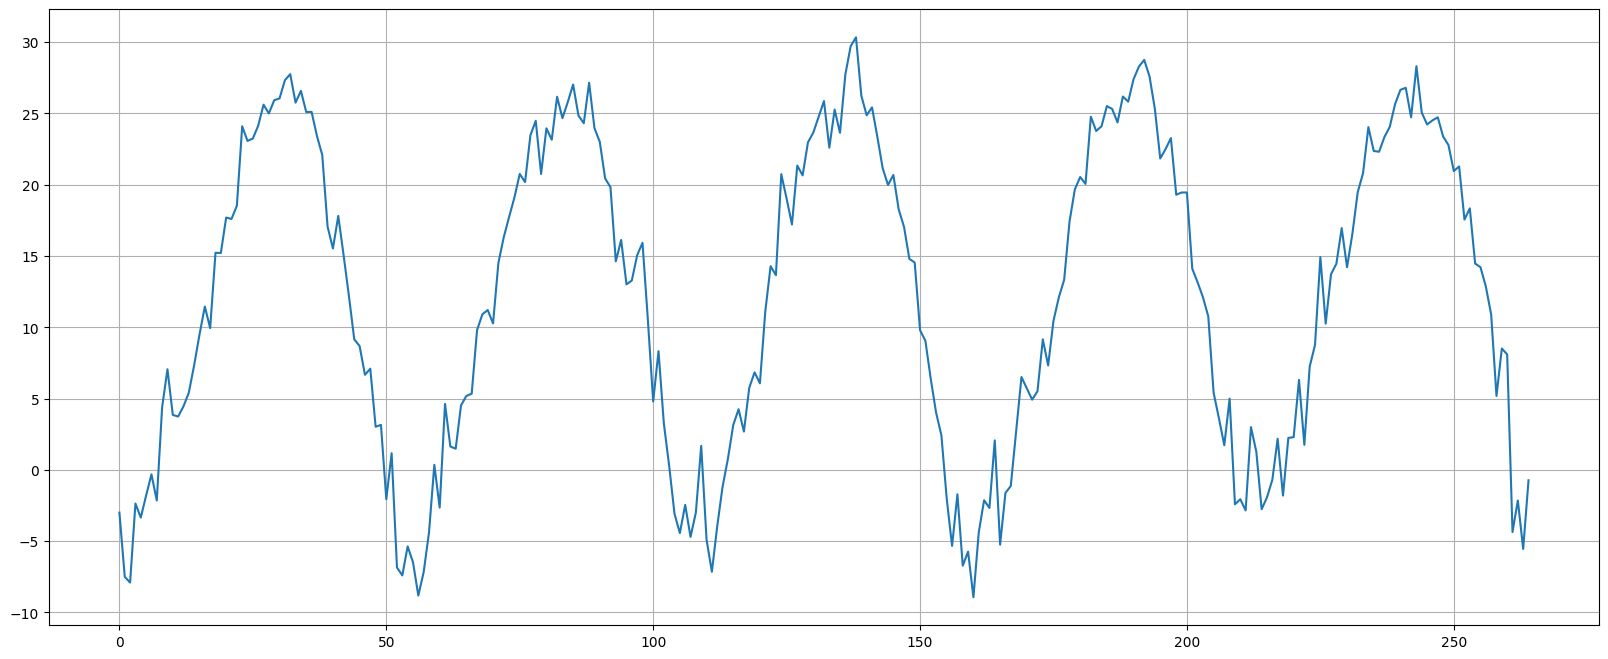

In [5]:
plt.figure(figsize = (20,8))
plt.plot(data.AvgTemp)
plt.grid()
plt.show()

##3.데이터 준비

### (1) y 만들기

In [6]:
data['y'] = data['AvgTemp'].shift(-1)
data.dropna(axis = 0, inplace = True)
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


### (2) x, y 분리

In [9]:
x = data.loc[:, ['AvgTemp']]
y = data.loc[:,'y']

### (3) 스케일링

In [10]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

In [11]:
x.shape, y.shape

((264, 1), (264,))

### (4) 3차원 구조 만들기

In [12]:
x2, y2 = temporalize(x, y, 4)
x2.shape, y2.shape

((261, 4, 1), (261,))

In [13]:
x2[:2]

array([[[0.15106693],
        [0.0364937 ],
        [0.02630941],
        [0.16743453]],

       [[0.0364937 ],
        [0.02630941],
        [0.16743453],
        [0.14233754]]])

In [14]:
y[:7], y2[:2]

(0   -7.500000
 1   -7.900000
 2   -2.357143
 3   -3.342857
 4   -1.800000
 5   -0.314286
 6   -2.142857
 Name: y, dtype: float64,
 array([-3.34285714, -1.8       ]))

### (5) 데이터 분할

* shuffle = False : 섞지 마라.(랜덤 분할 하지 마라)
* test_size= 53 : 만약 소수로 표현하면 비율로 나눠라. 자연수면 갯수로 잘라라.

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

In [16]:
x_train.shape, y_train.shape

((208, 4, 1), (208,))

In [17]:
x_val.shape, y_val.shape

((53, 4, 1), (53,))

## 4.RNN : 무작정 모델링

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [18]:
x_train.shape

(208, 4, 1)

In [19]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 다음 구조를 그대로 설계해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures))
    * Dense(1)

In [20]:
clear_session()

model = Sequential([SimpleRNN(8, input_shape = (timestep, nfeatures)),
                    Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89 (356.00 Byte)
Trainable params: 89 (356.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [21]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
6/6 [==============================] - 1s 44ms/step - loss: 252.1093 - val_loss: 311.0917
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 223.2636 - val_loss: 280.9619
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 204.8874 - val_loss: 259.9849
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 192.5124 - val_loss: 244.2410
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 183.1424 - val_loss: 231.5084
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 175.2541 - val_loss: 219.6011
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 167.9999 - val_loss: 207.1277
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 160.5649 - val_loss: 194.7667
Epoch 9/100
6/6 [==============================] - 0s 6ms/step - loss: 153.6072 - val_loss: 183.9297
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 147.7898 - val_lo

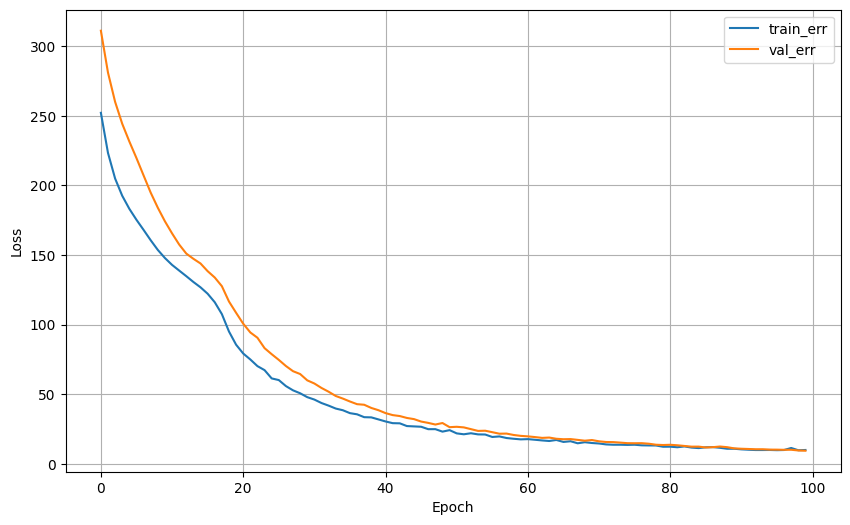

In [22]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [23]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 5ms/step


In [25]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

2.929634170775389
0.6383328429607207


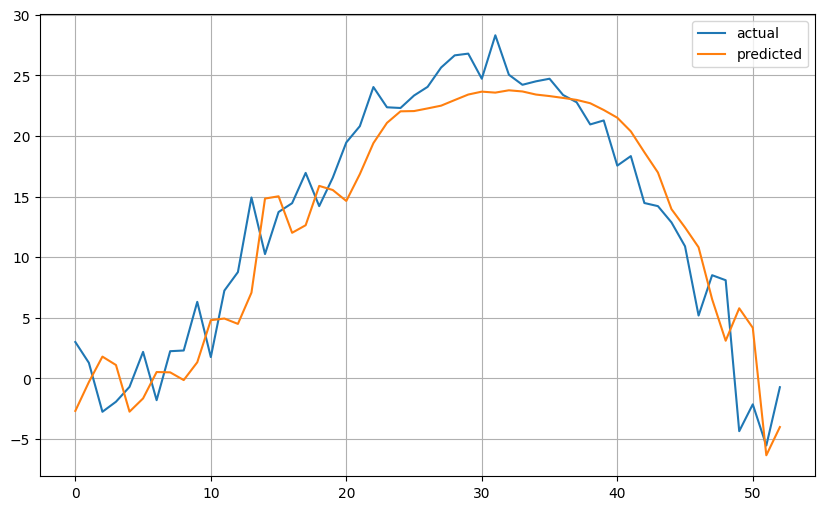

In [24]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 5.RNN 모델링②

### (1) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [26]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (2) 모델 구조 설계
* 이제 RNN 레이어를 추가해 봅시다.
    * SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences = True)
    * SimpleRNN(4)
    * Dense(1)

In [27]:
clear_session()

model = Sequential([SimpleRNN(8, input_shape = (timestep, nfeatures), return_sequences=True),
                    SimpleRNN(4),
                    Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 8)              80        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 52        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 137 (548.00 Byte)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (3) 컴파일 및 학습
* 다음 조건으로 학습해 봅시다.
    * epochs = 100
    * learning_rate = 0.01

In [33]:
model.compile(optimizer = Adam(lr = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
6/6 [==============================] - 1s 46ms/step - loss: 159.8224 - val_loss: 216.3618
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 159.2324 - val_loss: 215.6424
Epoch 3/100
6/6 [==============================] - 0s 6ms/step - loss: 158.6808 - val_loss: 214.9179
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 158.1424 - val_loss: 214.1844
Epoch 5/100
6/6 [==============================] - 0s 6ms/step - loss: 157.6109 - val_loss: 213.4754
Epoch 6/100
6/6 [==============================] - 0s 6ms/step - loss: 157.0682 - val_loss: 212.7411
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 156.5235 - val_loss: 212.0225
Epoch 8/100
6/6 [==============================] - 0s 6ms/step - loss: 155.9890 - val_loss: 211.3130
Epoch 9/100
6/6 [==============================] - 0s 6ms/step - loss: 155.4738 - val_loss: 210.6030
Epoch 10/100
6/6 [==============================] - 0s 6ms/step - loss: 154.9746 - val_los

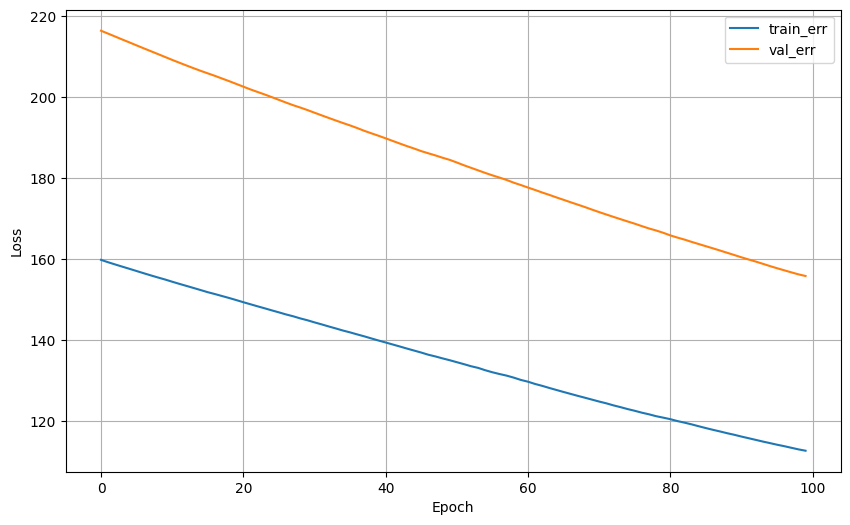

In [34]:
# 학습 곡선을 그려봅시다.
dl_history_plot(history)

### (4) 예측 및 평가

In [35]:
# 예측
pred = model.predict(x_val)

2/2 [==============================] - 0s 4ms/step


In [36]:
# 평가
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

9.504740553050054
0.9965649613771446


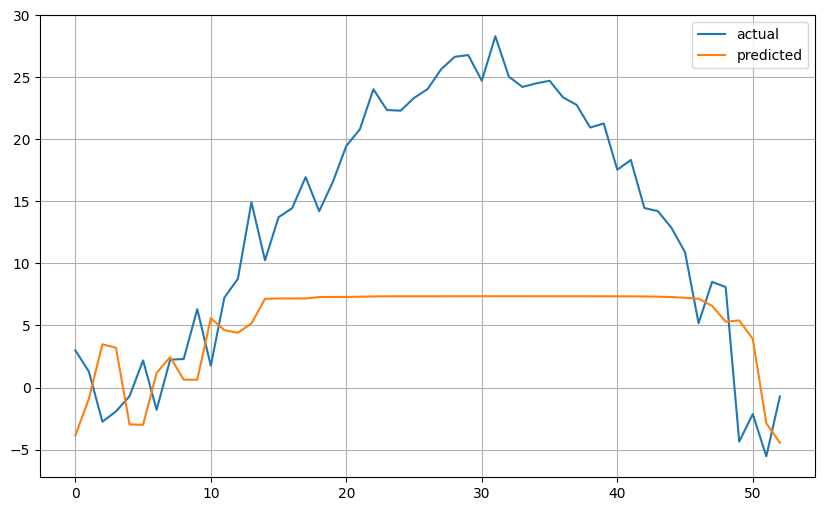

In [37]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 6.RNN 모델링③
* 5번 모델의 SimpleRNN을 LSTM 로 이름만 바꿔봅시다.

### (1) 데이터 준비

* timestep

In [38]:
timestep = 4
x2, y2 = temporalize(x, y, timestep)
x2.shape, y2.shape

((261, 4, 1), (261,))

* 데이터 분할

In [39]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [40]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


In [42]:
model = Sequential([LSTM(8, input_shape = (timestep, nfeatures), return_sequences = True),
                    LSTM(4),
                    Dense(1)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 8)              320       
                                                                 
 lstm_3 (LSTM)               (None, 4)                 208       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 533 (2.08 KB)
Trainable params: 533 (2.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### (4) 컴파일 및 학습

In [43]:
model.compile(optimizer = Adam(lr = 0.01), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 100, validation_split = .2).history

Epoch 1/100
6/6 [==============================] - 3s 119ms/step - loss: 254.5578 - val_loss: 342.8163
Epoch 2/100
6/6 [==============================] - 0s 8ms/step - loss: 253.9500 - val_loss: 341.9805
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 253.3394 - val_loss: 341.1898
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 252.7582 - val_loss: 340.4030
Epoch 5/100
6/6 [==============================] - 0s 8ms/step - loss: 252.2007 - val_loss: 339.6052
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 251.6258 - val_loss: 338.7859
Epoch 7/100
6/6 [==============================] - 0s 7ms/step - loss: 251.0093 - val_loss: 337.9235
Epoch 8/100
6/6 [==============================] - 0s 7ms/step - loss: 250.3871 - val_loss: 337.0042
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 249.7193 - val_loss: 336.0533
Epoch 10/100
6/6 [==============================] - 0s 7ms/step - loss: 249.0139 - val_l

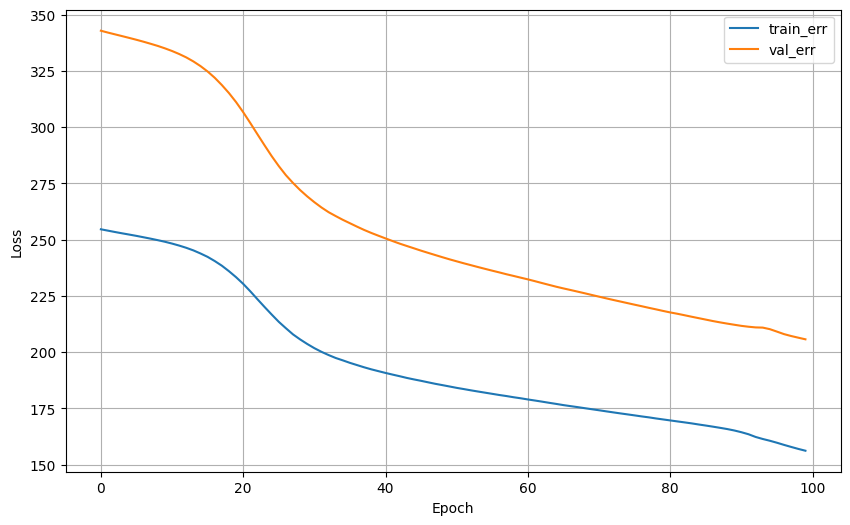

In [44]:
dl_history_plot(history)

### (5) 예측 및 평가

In [45]:
pred = model.predict(x_val)

2/2 [==============================] - 0s 4ms/step


In [46]:
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

10.776731423822767
1.0065948413866301


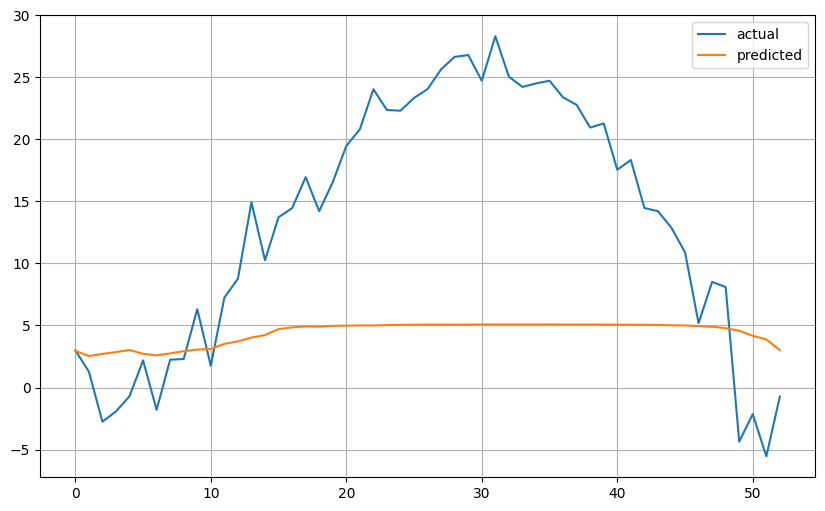

In [47]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()

## 7.자유롭게 모델링~!
* 다음 항목을 조정하며 모델링을 수행해 봅시다.
    * timestep
    * 레이어와 노드수
    * learning_rate, epochs


### (1) 데이터 준비

* timestep

In [48]:
timestep = 8
x2, y2 = temporalize(x, y, timestep)
x2.shape, y2.shape

((257, 8, 1), (257,))

* 데이터 분할

In [49]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False)

### (2) 입력 구조(shape)
* 분석 단위 : 2차원 ( timesteps, nfeatures)

In [50]:
timestep = x_train.shape[1]
nfeatures = x_train.shape[2]

### (3) 모델 구조 설계


In [101]:
clear_session()
model = Sequential([SimpleRNN(10, input_shape = (timestep, nfeatures), return_sequences = True),
                    SimpleRNN(8, return_sequences = True),
                    SimpleRNN(8, return_sequences = True),
                    SimpleRNN(4, return_sequences = True),
                    SimpleRNN(4),
                    Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8, 10)             120       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8, 8)              152       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8, 8)              136       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 8, 4)              52        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 4)                 36        
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 501 (1.96 KB)
Trainable params: 501 (1.96 

### (4) 컴파일 및 학습

In [102]:
model.compile(optimizer = Adam(lr = 0.001), loss = 'mse' )
history = model.fit(x_train, y_train, epochs = 500, validation_split = .2).history

Epoch 1/500
6/6 [==============================] - 3s 86ms/step - loss: 213.9504 - val_loss: 269.5733
Epoch 2/500
6/6 [==============================] - 0s 9ms/step - loss: 200.3321 - val_loss: 265.2089
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 198.6878 - val_loss: 264.4216
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 198.0951 - val_loss: 263.4854
Epoch 5/500
6/6 [==============================] - 0s 10ms/step - loss: 197.4138 - val_loss: 262.4183
Epoch 6/500
6/6 [==============================] - 0s 10ms/step - loss: 196.7124 - val_loss: 261.4875
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 196.0569 - val_loss: 260.7481
Epoch 8/500
6/6 [==============================] - 0s 10ms/step - loss: 195.4195 - val_loss: 260.1107
Epoch 9/500
6/6 [==============================] - 0s 9ms/step - loss: 194.7297 - val_loss: 259.4264
Epoch 10/500
6/6 [==============================] - 0s 10ms/step - loss: 193.9344 - va

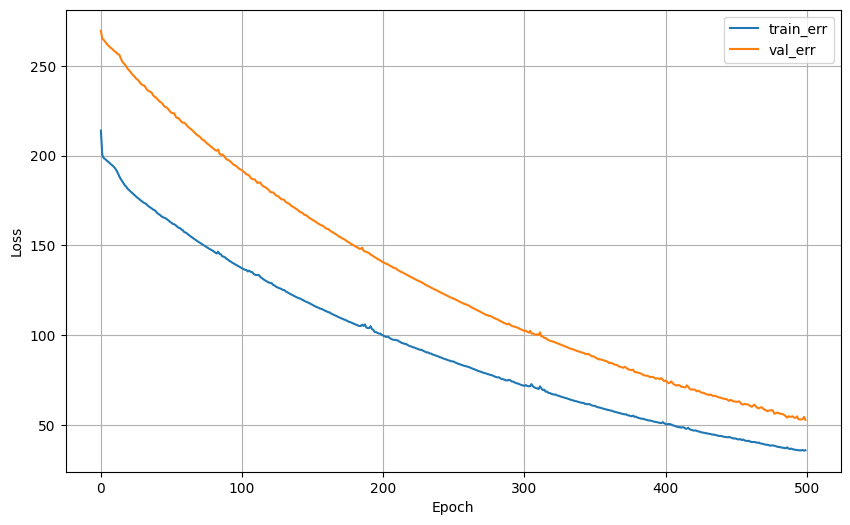

In [103]:
dl_history_plot(history)

### (5) 예측 및 평가

In [104]:
pred = model.predict(x_val)

2/2 [==============================] - 1s 6ms/step


In [105]:
print(mean_absolute_error(y_val, pred))
print(mean_absolute_percentage_error(y_val, pred))

5.185175586330342
0.7134648638989044


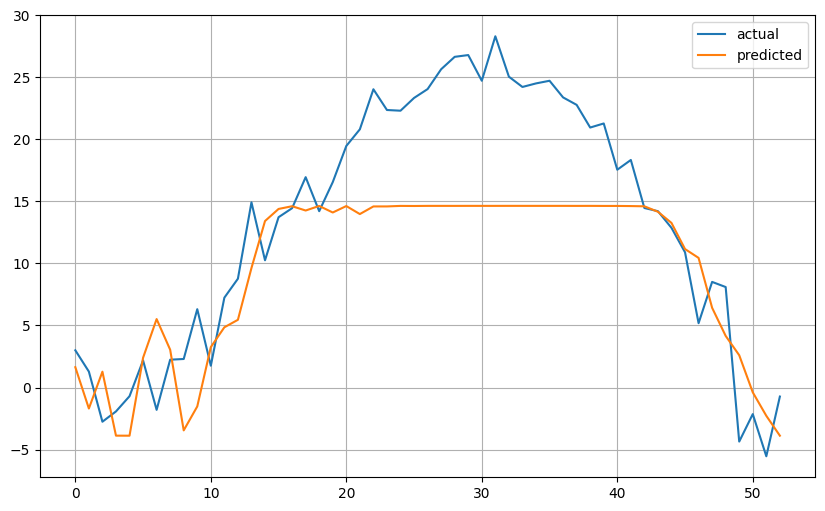

In [106]:
plt.figure(figsize = (10,6))
plt.plot(y_val, label = 'actual')
plt.plot(pred, label = 'predicted')
plt.legend()
plt.grid()
plt.show()